In [87]:
import numpy as np
import pandas as pd
import matplotlib as plt
import re
import lightgbm as lgb
import datetime as dt
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

In [90]:
borrar = ["Opportunity_Name", "ID", "Brand", "Product_Type", "ASP_converted_Currency", 
          "Prod_Category_A", "Product_Category_B", "Actual_Delivery_Date", "Last_Activity", 
          "ASP_converted_Currency", "Prod_Category_A", "Product_Name", "Delivery_Year","Product_Family", "Account_Name"]

useless = ["Submitted_for_Approval", "Account_Type", "Delivery_Terms", "Size", "Price", "ASP_Currency", 
           "Total_Amount_Currency", "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type"]

dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date"]

target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [91]:
def preprocess(data):
    
    # elimino caracteres prohibidos en los headers
    
    data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
        
    for d in dates:
        data[d] = pd.to_datetime(data[d])

    # agrego features
    
    data["Contacts"] = data.groupby("Opportunity_ID", sort = False)["Opportunity_ID"].transform("count")
    data["Delivery_Difference"] = (data["Planned_Delivery_End_Date"] - data["Planned_Delivery_Start_Date"]).dt.days
    data["Same_Owner"] = (data.Opportunity_Owner == data.Account_Owner) & (data.Opportunity_Owner == data.Last_Modified_By)
    data["Has_Brand"] = data.Brand != "None"
    data["Has_Contract"] = data.Sales_Contract_No != "None"
    data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")    
    #data.loc[data.TRF == 0, "TRF_Cat"] = 0
    #data.loc[(1 <= data.TRF) & (data.TRF <= 7), "TRF_Cat"] = 1
    #data.loc[data.TRF > 7, "TRF_Cat"] = 2
    data["Sales"] = data.groupby("Account_Name", sort=False)["Opportunity_ID"].transform(lambda x: x.nunique())
    
    data["Concrete_Offer"] = (data["Planned_Delivery_End_Date"] - data["Opportunity_Created_Date"]).dt.days < 60
    data["Offer_Duration"] = (data["Quote_Expiry_Date"] - data["Opportunity_Created_Date"]).dt.days < 60
    
    #data["Total_Volume"] = data.groupby("Opportunity_ID", sort = False)["Total_Amount"].transform("sum")
    data["ASP_max"] = data.groupby("Opportunity_ID", sort = False)["ASP"].transform("max")
    data["ASP_converted_max"] = data.groupby("Opportunity_ID", sort = False)["ASP_converted"].transform("max")
    data.drop(["ASP", "ASP_converted"], axis = 1, inplace = True)

    
    # fabri
    
    #data["Territory_Defined"] = data.Territory != "None"
    data["Past_Quote"] = (data["Last_Modified_Date"] - data["Quote_Expiry_Date"]).dt.days
    data["Month"] = data.Month.str[-2:].astype(int)
    
    # casteo a categoricas varias columnas
    categorical = [x for x in data.columns if data[x].dtype == "object"]
    for c in categorical:       
        data[c] = data[c].astype('category')
    
    for c in dates:
        data[c] = pd.to_datetime(data[c])
    
    data["Contact_Duration"] = (data[dates].max(axis = 1) - data[dates].min(axis = 1)).dt.days
    
    # limpio columnas
    
    data = data.drop(borrar + useless + dates + ["Delivery_Quarter"], axis = 1)
    
    #data.drop(data[(data.Contacts > 1) & (data.ASP.isna())].index, inplace = True)
    #data = data.drop_duplicates([x for x in data.columns if x != 'ID'])
    
    return (data)

In [92]:
import catboost as ctb

In [93]:
data = pd.read_csv("Entrenamieto_ECI_2020.csv")

In [94]:
prep = preprocess(data)

In [95]:
prep = prep[(prep.Stage == "Closed Won") | (prep.Stage == "Closed Lost")]
prep.Stage = prep.Stage.replace({"Closed Won": 1, "Closed Lost": 0})

In [96]:
prep.Stage.value_counts()

1    9533
0    7350
Name: Stage, dtype: int64

In [97]:
x_train, x_test, y_train, y_test = train_test_split(prep, prep.Stage, test_size = 0.3, random_state = 0)

In [98]:
cat_vars = [x for x in x_train.drop(target, axis=1).select_dtypes('category').columns if x != 'Stage']

In [99]:
cat_indexes = [x_train.drop(target, axis=1).columns.get_loc(x) for x in cat_vars]

In [100]:
model = ctb.CatBoostClassifier(num_boost_round = 5000,
                               learning_rate = 0.015,
                               l2_leaf_reg = 3.5,
                               depth = 8,
                               max_bin = 400,
                               num_leaves = 31,
                               rsm = 0.9,
                               eval_metric = 'Logloss',
                               use_best_model = True,
                               one_hot_max_size = 30,
                               random_seed = 42)

In [101]:
model.fit(x_train.drop(target, axis=1), y_train, eval_set=(x_test.drop(target, axis=1), y_test), cat_features=cat_indexes, early_stopping_rounds=800)

0:	learn: 0.6682937	test: 0.6686989	best: 0.6686989 (0)	total: 199ms	remaining: 16m 32s
1:	learn: 0.6446877	test: 0.6454583	best: 0.6454583 (1)	total: 289ms	remaining: 12m 1s
2:	learn: 0.6207261	test: 0.6217555	best: 0.6217555 (2)	total: 345ms	remaining: 9m 33s
3:	learn: 0.5980565	test: 0.5992098	best: 0.5992098 (3)	total: 421ms	remaining: 8m 45s
4:	learn: 0.5763051	test: 0.5777469	best: 0.5777469 (4)	total: 504ms	remaining: 8m 23s
5:	learn: 0.5562260	test: 0.5579314	best: 0.5579314 (5)	total: 585ms	remaining: 8m 6s
6:	learn: 0.5368379	test: 0.5389563	best: 0.5389563 (6)	total: 720ms	remaining: 8m 33s
7:	learn: 0.5186900	test: 0.5211130	best: 0.5211130 (7)	total: 805ms	remaining: 8m 22s
8:	learn: 0.4992815	test: 0.5020107	best: 0.5020107 (8)	total: 918ms	remaining: 8m 29s
9:	learn: 0.4826701	test: 0.4855313	best: 0.4855313 (9)	total: 1.04s	remaining: 8m 41s
10:	learn: 0.4652152	test: 0.4683534	best: 0.4683534 (10)	total: 1.35s	remaining: 10m 12s
11:	learn: 0.4503718	test: 0.4538390	bes

94:	learn: 0.1204179	test: 0.1318064	best: 0.1318064 (94)	total: 7.01s	remaining: 6m 1s
95:	learn: 0.1195969	test: 0.1310381	best: 0.1310381 (95)	total: 7.07s	remaining: 6m 1s
96:	learn: 0.1189991	test: 0.1305456	best: 0.1305456 (96)	total: 7.12s	remaining: 6m
97:	learn: 0.1183160	test: 0.1298802	best: 0.1298802 (97)	total: 7.18s	remaining: 5m 59s
98:	learn: 0.1176544	test: 0.1293089	best: 0.1293089 (98)	total: 7.25s	remaining: 5m 58s
99:	learn: 0.1171789	test: 0.1288775	best: 0.1288775 (99)	total: 7.3s	remaining: 5m 57s
100:	learn: 0.1165855	test: 0.1283662	best: 0.1283662 (100)	total: 7.35s	remaining: 5m 56s
101:	learn: 0.1160463	test: 0.1278673	best: 0.1278673 (101)	total: 7.41s	remaining: 5m 55s
102:	learn: 0.1154635	test: 0.1274092	best: 0.1274092 (102)	total: 7.46s	remaining: 5m 54s
103:	learn: 0.1150330	test: 0.1269708	best: 0.1269708 (103)	total: 7.52s	remaining: 5m 54s
104:	learn: 0.1146524	test: 0.1266662	best: 0.1266662 (104)	total: 7.62s	remaining: 5m 55s
105:	learn: 0.1143

185:	learn: 0.0909590	test: 0.1061520	best: 0.1061520 (185)	total: 13.7s	remaining: 5m 54s
186:	learn: 0.0906935	test: 0.1059394	best: 0.1059394 (186)	total: 13.8s	remaining: 5m 55s
187:	learn: 0.0904904	test: 0.1057991	best: 0.1057991 (187)	total: 13.9s	remaining: 5m 55s
188:	learn: 0.0903865	test: 0.1057256	best: 0.1057256 (188)	total: 14s	remaining: 5m 55s
189:	learn: 0.0902819	test: 0.1056540	best: 0.1056540 (189)	total: 14s	remaining: 5m 54s
190:	learn: 0.0900669	test: 0.1054728	best: 0.1054728 (190)	total: 14.1s	remaining: 5m 54s
191:	learn: 0.0898411	test: 0.1052649	best: 0.1052649 (191)	total: 14.1s	remaining: 5m 53s
192:	learn: 0.0896393	test: 0.1050538	best: 0.1050538 (192)	total: 14.2s	remaining: 5m 53s
193:	learn: 0.0894326	test: 0.1049106	best: 0.1049106 (193)	total: 14.3s	remaining: 5m 53s
194:	learn: 0.0892892	test: 0.1047559	best: 0.1047559 (194)	total: 14.3s	remaining: 5m 53s
195:	learn: 0.0891395	test: 0.1046233	best: 0.1046233 (195)	total: 14.4s	remaining: 5m 53s
196

277:	learn: 0.0761904	test: 0.0946013	best: 0.0946013 (277)	total: 20.2s	remaining: 5m 42s
278:	learn: 0.0760814	test: 0.0945185	best: 0.0945185 (278)	total: 20.2s	remaining: 5m 42s
279:	learn: 0.0759489	test: 0.0943893	best: 0.0943893 (279)	total: 20.3s	remaining: 5m 42s
280:	learn: 0.0757723	test: 0.0942212	best: 0.0942212 (280)	total: 20.4s	remaining: 5m 41s
281:	learn: 0.0756374	test: 0.0940761	best: 0.0940761 (281)	total: 20.4s	remaining: 5m 41s
282:	learn: 0.0755261	test: 0.0939962	best: 0.0939962 (282)	total: 20.5s	remaining: 5m 41s
283:	learn: 0.0754639	test: 0.0939632	best: 0.0939632 (283)	total: 20.5s	remaining: 5m 40s
284:	learn: 0.0753858	test: 0.0939443	best: 0.0939443 (284)	total: 20.6s	remaining: 5m 40s
285:	learn: 0.0752878	test: 0.0938810	best: 0.0938810 (285)	total: 20.6s	remaining: 5m 40s
286:	learn: 0.0751613	test: 0.0937587	best: 0.0937587 (286)	total: 20.7s	remaining: 5m 40s
287:	learn: 0.0749326	test: 0.0935517	best: 0.0935517 (287)	total: 20.8s	remaining: 5m 39s

369:	learn: 0.0668995	test: 0.0881913	best: 0.0881913 (369)	total: 27s	remaining: 5m 37s
370:	learn: 0.0668062	test: 0.0881814	best: 0.0881814 (370)	total: 27s	remaining: 5m 37s
371:	learn: 0.0667926	test: 0.0881833	best: 0.0881814 (370)	total: 27.1s	remaining: 5m 36s
372:	learn: 0.0666796	test: 0.0880881	best: 0.0880881 (372)	total: 27.1s	remaining: 5m 36s
373:	learn: 0.0666269	test: 0.0880503	best: 0.0880503 (373)	total: 27.2s	remaining: 5m 36s
374:	learn: 0.0665158	test: 0.0879985	best: 0.0879985 (374)	total: 27.3s	remaining: 5m 36s
375:	learn: 0.0664559	test: 0.0879562	best: 0.0879562 (375)	total: 27.3s	remaining: 5m 36s
376:	learn: 0.0663245	test: 0.0878384	best: 0.0878384 (376)	total: 27.4s	remaining: 5m 36s
377:	learn: 0.0662644	test: 0.0877894	best: 0.0877894 (377)	total: 27.5s	remaining: 5m 35s
378:	learn: 0.0662329	test: 0.0877873	best: 0.0877873 (378)	total: 27.5s	remaining: 5m 35s
379:	learn: 0.0661744	test: 0.0877554	best: 0.0877554 (379)	total: 27.6s	remaining: 5m 35s
380

460:	learn: 0.0601575	test: 0.0837413	best: 0.0837413 (460)	total: 32.6s	remaining: 5m 21s
461:	learn: 0.0600566	test: 0.0836498	best: 0.0836498 (461)	total: 32.7s	remaining: 5m 20s
462:	learn: 0.0599826	test: 0.0836187	best: 0.0836187 (462)	total: 32.7s	remaining: 5m 20s
463:	learn: 0.0598242	test: 0.0835289	best: 0.0835289 (463)	total: 32.8s	remaining: 5m 20s
464:	learn: 0.0597426	test: 0.0834768	best: 0.0834768 (464)	total: 32.9s	remaining: 5m 20s
465:	learn: 0.0596791	test: 0.0834338	best: 0.0834338 (465)	total: 32.9s	remaining: 5m 20s
466:	learn: 0.0596503	test: 0.0834169	best: 0.0834169 (466)	total: 33s	remaining: 5m 20s
467:	learn: 0.0596333	test: 0.0834115	best: 0.0834115 (467)	total: 33s	remaining: 5m 20s
468:	learn: 0.0596139	test: 0.0833969	best: 0.0833969 (468)	total: 33.1s	remaining: 5m 19s
469:	learn: 0.0595104	test: 0.0833714	best: 0.0833714 (469)	total: 33.2s	remaining: 5m 19s
470:	learn: 0.0594642	test: 0.0833586	best: 0.0833586 (470)	total: 33.2s	remaining: 5m 19s
471

553:	learn: 0.0552567	test: 0.0808003	best: 0.0808003 (553)	total: 38.5s	remaining: 5m 9s
554:	learn: 0.0551895	test: 0.0807686	best: 0.0807686 (554)	total: 38.6s	remaining: 5m 9s
555:	learn: 0.0551770	test: 0.0807605	best: 0.0807605 (555)	total: 38.6s	remaining: 5m 8s
556:	learn: 0.0551429	test: 0.0807475	best: 0.0807475 (556)	total: 38.7s	remaining: 5m 8s
557:	learn: 0.0550189	test: 0.0806072	best: 0.0806072 (557)	total: 38.8s	remaining: 5m 8s
558:	learn: 0.0550173	test: 0.0806087	best: 0.0806072 (557)	total: 38.8s	remaining: 5m 8s
559:	learn: 0.0550006	test: 0.0805854	best: 0.0805854 (559)	total: 38.8s	remaining: 5m 7s
560:	learn: 0.0549971	test: 0.0805841	best: 0.0805841 (560)	total: 38.9s	remaining: 5m 7s
561:	learn: 0.0549505	test: 0.0805794	best: 0.0805794 (561)	total: 38.9s	remaining: 5m 7s
562:	learn: 0.0548564	test: 0.0805482	best: 0.0805482 (562)	total: 39s	remaining: 5m 7s
563:	learn: 0.0547735	test: 0.0805049	best: 0.0805049 (563)	total: 39.1s	remaining: 5m 7s
564:	learn: 

647:	learn: 0.0507499	test: 0.0779129	best: 0.0779129 (647)	total: 43.6s	remaining: 4m 53s
648:	learn: 0.0506594	test: 0.0778309	best: 0.0778309 (648)	total: 43.7s	remaining: 4m 53s
649:	learn: 0.0506305	test: 0.0777890	best: 0.0777890 (649)	total: 43.8s	remaining: 4m 52s
650:	learn: 0.0505524	test: 0.0777818	best: 0.0777818 (650)	total: 43.8s	remaining: 4m 52s
651:	learn: 0.0504310	test: 0.0776963	best: 0.0776963 (651)	total: 43.9s	remaining: 4m 52s
652:	learn: 0.0504058	test: 0.0776791	best: 0.0776791 (652)	total: 44s	remaining: 4m 52s
653:	learn: 0.0503703	test: 0.0776442	best: 0.0776442 (653)	total: 44s	remaining: 4m 52s
654:	learn: 0.0502896	test: 0.0775984	best: 0.0775984 (654)	total: 44.1s	remaining: 4m 52s
655:	learn: 0.0502371	test: 0.0775566	best: 0.0775566 (655)	total: 44.1s	remaining: 4m 52s
656:	learn: 0.0502119	test: 0.0775464	best: 0.0775464 (656)	total: 44.2s	remaining: 4m 52s
657:	learn: 0.0502094	test: 0.0775426	best: 0.0775426 (657)	total: 44.2s	remaining: 4m 51s
658

739:	learn: 0.0471541	test: 0.0756121	best: 0.0756121 (739)	total: 48.8s	remaining: 4m 40s
740:	learn: 0.0471181	test: 0.0755986	best: 0.0755986 (740)	total: 48.8s	remaining: 4m 40s
741:	learn: 0.0470979	test: 0.0755795	best: 0.0755795 (741)	total: 48.9s	remaining: 4m 40s
742:	learn: 0.0470127	test: 0.0754931	best: 0.0754931 (742)	total: 49s	remaining: 4m 40s
743:	learn: 0.0469243	test: 0.0754334	best: 0.0754334 (743)	total: 49s	remaining: 4m 40s
744:	learn: 0.0469216	test: 0.0754312	best: 0.0754312 (744)	total: 49.1s	remaining: 4m 40s
745:	learn: 0.0467760	test: 0.0753538	best: 0.0753538 (745)	total: 49.1s	remaining: 4m 40s
746:	learn: 0.0467340	test: 0.0753595	best: 0.0753538 (745)	total: 49.2s	remaining: 4m 39s
747:	learn: 0.0467289	test: 0.0753574	best: 0.0753538 (745)	total: 49.2s	remaining: 4m 39s
748:	learn: 0.0467228	test: 0.0753496	best: 0.0753496 (748)	total: 49.3s	remaining: 4m 39s
749:	learn: 0.0467049	test: 0.0753384	best: 0.0753384 (749)	total: 49.3s	remaining: 4m 39s
750

832:	learn: 0.0434064	test: 0.0731791	best: 0.0731791 (832)	total: 54.4s	remaining: 4m 32s
833:	learn: 0.0434064	test: 0.0731791	best: 0.0731791 (833)	total: 54.4s	remaining: 4m 31s
834:	learn: 0.0433966	test: 0.0731708	best: 0.0731708 (834)	total: 54.5s	remaining: 4m 31s
835:	learn: 0.0433953	test: 0.0731640	best: 0.0731640 (835)	total: 54.5s	remaining: 4m 31s
836:	learn: 0.0433926	test: 0.0731567	best: 0.0731567 (836)	total: 54.5s	remaining: 4m 31s
837:	learn: 0.0433925	test: 0.0731566	best: 0.0731566 (837)	total: 54.5s	remaining: 4m 30s
838:	learn: 0.0433925	test: 0.0731566	best: 0.0731566 (838)	total: 54.5s	remaining: 4m 30s
839:	learn: 0.0433687	test: 0.0731585	best: 0.0731566 (838)	total: 54.6s	remaining: 4m 30s
840:	learn: 0.0433648	test: 0.0731552	best: 0.0731552 (840)	total: 54.6s	remaining: 4m 30s
841:	learn: 0.0433560	test: 0.0731495	best: 0.0731495 (841)	total: 54.7s	remaining: 4m 30s
842:	learn: 0.0432114	test: 0.0730360	best: 0.0730360 (842)	total: 54.8s	remaining: 4m 30s

923:	learn: 0.0413250	test: 0.0719939	best: 0.0719939 (923)	total: 59s	remaining: 4m 20s
924:	learn: 0.0412455	test: 0.0718948	best: 0.0718948 (924)	total: 59s	remaining: 4m 20s
925:	learn: 0.0412203	test: 0.0718856	best: 0.0718856 (925)	total: 59.1s	remaining: 4m 20s
926:	learn: 0.0411651	test: 0.0718567	best: 0.0718567 (926)	total: 59.2s	remaining: 4m 20s
927:	learn: 0.0411502	test: 0.0718505	best: 0.0718505 (927)	total: 59.2s	remaining: 4m 19s
928:	learn: 0.0411386	test: 0.0718339	best: 0.0718339 (928)	total: 59.3s	remaining: 4m 19s
929:	learn: 0.0410579	test: 0.0717869	best: 0.0717869 (929)	total: 59.4s	remaining: 4m 19s
930:	learn: 0.0410218	test: 0.0717434	best: 0.0717434 (930)	total: 59.5s	remaining: 4m 19s
931:	learn: 0.0410217	test: 0.0717433	best: 0.0717433 (931)	total: 59.5s	remaining: 4m 19s
932:	learn: 0.0410100	test: 0.0717341	best: 0.0717341 (932)	total: 59.5s	remaining: 4m 19s
933:	learn: 0.0410049	test: 0.0717312	best: 0.0717312 (933)	total: 59.6s	remaining: 4m 19s
934

1017:	learn: 0.0384123	test: 0.0702756	best: 0.0702756 (1017)	total: 1m 4s	remaining: 4m 13s
1018:	learn: 0.0383423	test: 0.0702624	best: 0.0702624 (1018)	total: 1m 4s	remaining: 4m 13s
1019:	learn: 0.0383196	test: 0.0702650	best: 0.0702624 (1018)	total: 1m 4s	remaining: 4m 13s
1020:	learn: 0.0382830	test: 0.0702472	best: 0.0702472 (1020)	total: 1m 4s	remaining: 4m 12s
1021:	learn: 0.0382781	test: 0.0702391	best: 0.0702391 (1021)	total: 1m 4s	remaining: 4m 12s
1022:	learn: 0.0382583	test: 0.0702402	best: 0.0702391 (1021)	total: 1m 5s	remaining: 4m 12s
1023:	learn: 0.0382352	test: 0.0702253	best: 0.0702253 (1023)	total: 1m 5s	remaining: 4m 12s
1024:	learn: 0.0382330	test: 0.0702251	best: 0.0702251 (1024)	total: 1m 5s	remaining: 4m 12s
1025:	learn: 0.0381804	test: 0.0702110	best: 0.0702110 (1025)	total: 1m 5s	remaining: 4m 12s
1026:	learn: 0.0381753	test: 0.0702122	best: 0.0702110 (1025)	total: 1m 5s	remaining: 4m 12s
1027:	learn: 0.0381725	test: 0.0702094	best: 0.0702094 (1027)	total: 1

1106:	learn: 0.0359650	test: 0.0687838	best: 0.0687837 (1105)	total: 1m 10s	remaining: 4m 8s
1107:	learn: 0.0359650	test: 0.0687838	best: 0.0687837 (1105)	total: 1m 10s	remaining: 4m 8s
1108:	learn: 0.0359122	test: 0.0687518	best: 0.0687518 (1108)	total: 1m 10s	remaining: 4m 9s
1109:	learn: 0.0358976	test: 0.0687459	best: 0.0687459 (1109)	total: 1m 11s	remaining: 4m 9s
1110:	learn: 0.0358957	test: 0.0687443	best: 0.0687443 (1110)	total: 1m 11s	remaining: 4m 9s
1111:	learn: 0.0358928	test: 0.0687430	best: 0.0687430 (1111)	total: 1m 11s	remaining: 4m 9s
1112:	learn: 0.0358459	test: 0.0687164	best: 0.0687164 (1112)	total: 1m 11s	remaining: 4m 9s
1113:	learn: 0.0358396	test: 0.0687162	best: 0.0687162 (1113)	total: 1m 11s	remaining: 4m 9s
1114:	learn: 0.0358285	test: 0.0687138	best: 0.0687138 (1114)	total: 1m 11s	remaining: 4m 9s
1115:	learn: 0.0357816	test: 0.0687036	best: 0.0687036 (1115)	total: 1m 11s	remaining: 4m 9s
1116:	learn: 0.0357396	test: 0.0686530	best: 0.0686530 (1116)	total: 1

1195:	learn: 0.0337347	test: 0.0675450	best: 0.0675450 (1195)	total: 1m 19s	remaining: 4m 11s
1196:	learn: 0.0337093	test: 0.0675335	best: 0.0675335 (1196)	total: 1m 19s	remaining: 4m 11s
1197:	learn: 0.0337075	test: 0.0675316	best: 0.0675316 (1197)	total: 1m 19s	remaining: 4m 11s
1198:	learn: 0.0336759	test: 0.0675188	best: 0.0675188 (1198)	total: 1m 19s	remaining: 4m 11s
1199:	learn: 0.0335902	test: 0.0674782	best: 0.0674782 (1199)	total: 1m 19s	remaining: 4m 11s
1200:	learn: 0.0335884	test: 0.0674751	best: 0.0674751 (1200)	total: 1m 19s	remaining: 4m 11s
1201:	learn: 0.0335105	test: 0.0674040	best: 0.0674040 (1201)	total: 1m 19s	remaining: 4m 10s
1202:	learn: 0.0334700	test: 0.0673947	best: 0.0673947 (1202)	total: 1m 19s	remaining: 4m 10s
1203:	learn: 0.0334560	test: 0.0673949	best: 0.0673947 (1202)	total: 1m 19s	remaining: 4m 10s
1204:	learn: 0.0334421	test: 0.0673861	best: 0.0673861 (1204)	total: 1m 19s	remaining: 4m 10s
1205:	learn: 0.0334336	test: 0.0673773	best: 0.0673773 (1205

1285:	learn: 0.0316988	test: 0.0664847	best: 0.0664818 (1284)	total: 1m 25s	remaining: 4m 6s
1286:	learn: 0.0316574	test: 0.0664545	best: 0.0664545 (1286)	total: 1m 25s	remaining: 4m 6s
1287:	learn: 0.0316574	test: 0.0664544	best: 0.0664544 (1287)	total: 1m 25s	remaining: 4m 6s
1288:	learn: 0.0316384	test: 0.0664592	best: 0.0664544 (1287)	total: 1m 25s	remaining: 4m 6s
1289:	learn: 0.0316045	test: 0.0664570	best: 0.0664544 (1287)	total: 1m 25s	remaining: 4m 5s
1290:	learn: 0.0315899	test: 0.0664533	best: 0.0664533 (1290)	total: 1m 25s	remaining: 4m 5s
1291:	learn: 0.0315527	test: 0.0664173	best: 0.0664173 (1291)	total: 1m 25s	remaining: 4m 5s
1292:	learn: 0.0315137	test: 0.0663949	best: 0.0663949 (1292)	total: 1m 25s	remaining: 4m 5s
1293:	learn: 0.0314638	test: 0.0663927	best: 0.0663927 (1293)	total: 1m 25s	remaining: 4m 5s
1294:	learn: 0.0314421	test: 0.0663852	best: 0.0663852 (1294)	total: 1m 25s	remaining: 4m 5s
1295:	learn: 0.0314056	test: 0.0663799	best: 0.0663799 (1295)	total: 1

1378:	learn: 0.0298388	test: 0.0656406	best: 0.0656406 (1378)	total: 1m 30s	remaining: 3m 57s
1379:	learn: 0.0298168	test: 0.0656395	best: 0.0656395 (1379)	total: 1m 30s	remaining: 3m 57s
1380:	learn: 0.0298091	test: 0.0656368	best: 0.0656368 (1380)	total: 1m 30s	remaining: 3m 57s
1381:	learn: 0.0297928	test: 0.0656366	best: 0.0656366 (1381)	total: 1m 30s	remaining: 3m 57s
1382:	learn: 0.0297466	test: 0.0656117	best: 0.0656117 (1382)	total: 1m 30s	remaining: 3m 57s
1383:	learn: 0.0297317	test: 0.0656073	best: 0.0656073 (1383)	total: 1m 30s	remaining: 3m 57s
1384:	learn: 0.0297211	test: 0.0656022	best: 0.0656022 (1384)	total: 1m 30s	remaining: 3m 57s
1385:	learn: 0.0296935	test: 0.0655785	best: 0.0655785 (1385)	total: 1m 30s	remaining: 3m 57s
1386:	learn: 0.0296536	test: 0.0655747	best: 0.0655747 (1386)	total: 1m 31s	remaining: 3m 57s
1387:	learn: 0.0295921	test: 0.0655285	best: 0.0655285 (1387)	total: 1m 31s	remaining: 3m 56s
1388:	learn: 0.0295502	test: 0.0655311	best: 0.0655285 (1387

1467:	learn: 0.0282237	test: 0.0648837	best: 0.0648837 (1467)	total: 1m 35s	remaining: 3m 49s
1468:	learn: 0.0281842	test: 0.0648510	best: 0.0648510 (1468)	total: 1m 35s	remaining: 3m 49s
1469:	learn: 0.0281695	test: 0.0648427	best: 0.0648427 (1469)	total: 1m 35s	remaining: 3m 49s
1470:	learn: 0.0281402	test: 0.0648323	best: 0.0648323 (1470)	total: 1m 35s	remaining: 3m 49s
1471:	learn: 0.0281345	test: 0.0648354	best: 0.0648323 (1470)	total: 1m 35s	remaining: 3m 49s
1472:	learn: 0.0280839	test: 0.0647862	best: 0.0647862 (1472)	total: 1m 35s	remaining: 3m 49s
1473:	learn: 0.0280787	test: 0.0647875	best: 0.0647862 (1472)	total: 1m 35s	remaining: 3m 49s
1474:	learn: 0.0280513	test: 0.0647956	best: 0.0647862 (1472)	total: 1m 35s	remaining: 3m 49s
1475:	learn: 0.0280147	test: 0.0648031	best: 0.0647862 (1472)	total: 1m 36s	remaining: 3m 49s
1476:	learn: 0.0279827	test: 0.0647855	best: 0.0647855 (1476)	total: 1m 36s	remaining: 3m 49s
1477:	learn: 0.0279811	test: 0.0647822	best: 0.0647822 (1477

1557:	learn: 0.0267685	test: 0.0641725	best: 0.0641725 (1557)	total: 1m 40s	remaining: 3m 42s
1558:	learn: 0.0267529	test: 0.0641615	best: 0.0641615 (1558)	total: 1m 40s	remaining: 3m 42s
1559:	learn: 0.0267212	test: 0.0641357	best: 0.0641357 (1559)	total: 1m 40s	remaining: 3m 42s
1560:	learn: 0.0267090	test: 0.0641319	best: 0.0641319 (1560)	total: 1m 40s	remaining: 3m 41s
1561:	learn: 0.0267090	test: 0.0641319	best: 0.0641319 (1561)	total: 1m 40s	remaining: 3m 41s
1562:	learn: 0.0267079	test: 0.0641306	best: 0.0641306 (1562)	total: 1m 40s	remaining: 3m 41s
1563:	learn: 0.0266957	test: 0.0641431	best: 0.0641306 (1562)	total: 1m 40s	remaining: 3m 41s
1564:	learn: 0.0266843	test: 0.0641346	best: 0.0641306 (1562)	total: 1m 40s	remaining: 3m 41s
1565:	learn: 0.0266589	test: 0.0641130	best: 0.0641130 (1565)	total: 1m 41s	remaining: 3m 41s
1566:	learn: 0.0266444	test: 0.0641108	best: 0.0641108 (1566)	total: 1m 41s	remaining: 3m 41s
1567:	learn: 0.0266444	test: 0.0641108	best: 0.0641108 (1566

1646:	learn: 0.0255900	test: 0.0636923	best: 0.0636923 (1646)	total: 1m 45s	remaining: 3m 35s
1647:	learn: 0.0255733	test: 0.0636734	best: 0.0636734 (1647)	total: 1m 46s	remaining: 3m 35s
1648:	learn: 0.0255605	test: 0.0636794	best: 0.0636734 (1647)	total: 1m 46s	remaining: 3m 35s
1649:	learn: 0.0255480	test: 0.0636724	best: 0.0636724 (1649)	total: 1m 46s	remaining: 3m 35s
1650:	learn: 0.0255373	test: 0.0636723	best: 0.0636723 (1650)	total: 1m 46s	remaining: 3m 35s
1651:	learn: 0.0255227	test: 0.0636692	best: 0.0636692 (1651)	total: 1m 46s	remaining: 3m 35s
1652:	learn: 0.0255152	test: 0.0636749	best: 0.0636692 (1651)	total: 1m 46s	remaining: 3m 35s
1653:	learn: 0.0255002	test: 0.0636769	best: 0.0636692 (1651)	total: 1m 46s	remaining: 3m 35s
1654:	learn: 0.0254962	test: 0.0636750	best: 0.0636692 (1651)	total: 1m 46s	remaining: 3m 35s
1655:	learn: 0.0254962	test: 0.0636750	best: 0.0636692 (1651)	total: 1m 46s	remaining: 3m 35s
1656:	learn: 0.0254722	test: 0.0636779	best: 0.0636692 (1651

1735:	learn: 0.0244738	test: 0.0633445	best: 0.0633402 (1733)	total: 1m 52s	remaining: 3m 31s
1736:	learn: 0.0244722	test: 0.0633424	best: 0.0633402 (1733)	total: 1m 52s	remaining: 3m 31s
1737:	learn: 0.0244535	test: 0.0633341	best: 0.0633341 (1737)	total: 1m 52s	remaining: 3m 31s
1738:	learn: 0.0244487	test: 0.0633314	best: 0.0633314 (1738)	total: 1m 52s	remaining: 3m 31s
1739:	learn: 0.0244164	test: 0.0632877	best: 0.0632877 (1739)	total: 1m 52s	remaining: 3m 31s
1740:	learn: 0.0244027	test: 0.0632752	best: 0.0632752 (1740)	total: 1m 52s	remaining: 3m 31s
1741:	learn: 0.0243940	test: 0.0632798	best: 0.0632752 (1740)	total: 1m 52s	remaining: 3m 31s
1742:	learn: 0.0243876	test: 0.0632769	best: 0.0632752 (1740)	total: 1m 53s	remaining: 3m 31s
1743:	learn: 0.0243773	test: 0.0632720	best: 0.0632720 (1743)	total: 1m 53s	remaining: 3m 31s
1744:	learn: 0.0243665	test: 0.0632876	best: 0.0632720 (1743)	total: 1m 53s	remaining: 3m 31s
1745:	learn: 0.0243599	test: 0.0632906	best: 0.0632720 (1743

1825:	learn: 0.0232741	test: 0.0628381	best: 0.0628381 (1825)	total: 2m 1s	remaining: 3m 30s
1826:	learn: 0.0232741	test: 0.0628380	best: 0.0628380 (1826)	total: 2m 1s	remaining: 3m 30s
1827:	learn: 0.0232739	test: 0.0628373	best: 0.0628373 (1827)	total: 2m 1s	remaining: 3m 30s
1828:	learn: 0.0232720	test: 0.0628369	best: 0.0628369 (1828)	total: 2m 1s	remaining: 3m 30s
1829:	learn: 0.0232610	test: 0.0628273	best: 0.0628273 (1829)	total: 2m 1s	remaining: 3m 30s
1830:	learn: 0.0232610	test: 0.0628273	best: 0.0628273 (1830)	total: 2m 1s	remaining: 3m 30s
1831:	learn: 0.0232506	test: 0.0628242	best: 0.0628242 (1831)	total: 2m 1s	remaining: 3m 30s
1832:	learn: 0.0232357	test: 0.0628163	best: 0.0628163 (1832)	total: 2m 1s	remaining: 3m 30s
1833:	learn: 0.0232232	test: 0.0628049	best: 0.0628049 (1833)	total: 2m 1s	remaining: 3m 30s
1834:	learn: 0.0232031	test: 0.0627988	best: 0.0627988 (1834)	total: 2m 1s	remaining: 3m 30s
1835:	learn: 0.0232031	test: 0.0627988	best: 0.0627988 (1835)	total: 2

1917:	learn: 0.0222998	test: 0.0624181	best: 0.0624181 (1917)	total: 2m 7s	remaining: 3m 24s
1918:	learn: 0.0222986	test: 0.0624160	best: 0.0624160 (1918)	total: 2m 7s	remaining: 3m 24s
1919:	learn: 0.0222967	test: 0.0624176	best: 0.0624160 (1918)	total: 2m 7s	remaining: 3m 24s
1920:	learn: 0.0222891	test: 0.0624120	best: 0.0624120 (1920)	total: 2m 7s	remaining: 3m 24s
1921:	learn: 0.0222839	test: 0.0624130	best: 0.0624120 (1920)	total: 2m 7s	remaining: 3m 24s
1922:	learn: 0.0222726	test: 0.0624130	best: 0.0624120 (1920)	total: 2m 7s	remaining: 3m 24s
1923:	learn: 0.0222570	test: 0.0624015	best: 0.0624015 (1923)	total: 2m 7s	remaining: 3m 24s
1924:	learn: 0.0222411	test: 0.0623915	best: 0.0623915 (1924)	total: 2m 7s	remaining: 3m 24s
1925:	learn: 0.0222217	test: 0.0623826	best: 0.0623826 (1925)	total: 2m 7s	remaining: 3m 24s
1926:	learn: 0.0222144	test: 0.0623755	best: 0.0623755 (1926)	total: 2m 8s	remaining: 3m 24s
1927:	learn: 0.0222095	test: 0.0623767	best: 0.0623755 (1926)	total: 2

2005:	learn: 0.0213858	test: 0.0619910	best: 0.0619865 (2004)	total: 2m 12s	remaining: 3m 17s
2006:	learn: 0.0213858	test: 0.0619909	best: 0.0619865 (2004)	total: 2m 12s	remaining: 3m 17s
2007:	learn: 0.0213758	test: 0.0619807	best: 0.0619807 (2007)	total: 2m 12s	remaining: 3m 17s
2008:	learn: 0.0213758	test: 0.0619807	best: 0.0619807 (2008)	total: 2m 12s	remaining: 3m 16s
2009:	learn: 0.0213758	test: 0.0619807	best: 0.0619807 (2008)	total: 2m 12s	remaining: 3m 16s
2010:	learn: 0.0213734	test: 0.0619773	best: 0.0619773 (2010)	total: 2m 12s	remaining: 3m 16s
2011:	learn: 0.0213670	test: 0.0619827	best: 0.0619773 (2010)	total: 2m 12s	remaining: 3m 16s
2012:	learn: 0.0213670	test: 0.0619827	best: 0.0619773 (2010)	total: 2m 12s	remaining: 3m 16s
2013:	learn: 0.0213611	test: 0.0619837	best: 0.0619773 (2010)	total: 2m 12s	remaining: 3m 16s
2014:	learn: 0.0213611	test: 0.0619836	best: 0.0619773 (2010)	total: 2m 12s	remaining: 3m 16s
2015:	learn: 0.0213473	test: 0.0619853	best: 0.0619773 (2010

2096:	learn: 0.0204880	test: 0.0616417	best: 0.0616408 (2095)	total: 2m 16s	remaining: 3m 9s
2097:	learn: 0.0204721	test: 0.0616507	best: 0.0616408 (2095)	total: 2m 16s	remaining: 3m 9s
2098:	learn: 0.0204697	test: 0.0616535	best: 0.0616408 (2095)	total: 2m 16s	remaining: 3m 9s
2099:	learn: 0.0204697	test: 0.0616534	best: 0.0616408 (2095)	total: 2m 16s	remaining: 3m 8s
2100:	learn: 0.0204697	test: 0.0616535	best: 0.0616408 (2095)	total: 2m 16s	remaining: 3m 8s
2101:	learn: 0.0204581	test: 0.0616502	best: 0.0616408 (2095)	total: 2m 16s	remaining: 3m 8s
2102:	learn: 0.0204393	test: 0.0616731	best: 0.0616408 (2095)	total: 2m 17s	remaining: 3m 8s
2103:	learn: 0.0204392	test: 0.0616731	best: 0.0616408 (2095)	total: 2m 17s	remaining: 3m 8s
2104:	learn: 0.0204159	test: 0.0616533	best: 0.0616408 (2095)	total: 2m 17s	remaining: 3m 8s
2105:	learn: 0.0203878	test: 0.0616537	best: 0.0616408 (2095)	total: 2m 17s	remaining: 3m 8s
2106:	learn: 0.0203810	test: 0.0616458	best: 0.0616408 (2095)	total: 2

2185:	learn: 0.0195931	test: 0.0614217	best: 0.0614212 (2178)	total: 2m 21s	remaining: 3m 2s
2186:	learn: 0.0195571	test: 0.0614240	best: 0.0614212 (2178)	total: 2m 21s	remaining: 3m 1s
2187:	learn: 0.0195373	test: 0.0614257	best: 0.0614212 (2178)	total: 2m 21s	remaining: 3m 1s
2188:	learn: 0.0195244	test: 0.0614117	best: 0.0614117 (2188)	total: 2m 21s	remaining: 3m 1s
2189:	learn: 0.0195208	test: 0.0614086	best: 0.0614086 (2189)	total: 2m 21s	remaining: 3m 1s
2190:	learn: 0.0195149	test: 0.0614216	best: 0.0614086 (2189)	total: 2m 21s	remaining: 3m 1s
2191:	learn: 0.0194850	test: 0.0614240	best: 0.0614086 (2189)	total: 2m 21s	remaining: 3m 1s
2192:	learn: 0.0194617	test: 0.0614230	best: 0.0614086 (2189)	total: 2m 21s	remaining: 3m 1s
2193:	learn: 0.0194493	test: 0.0614172	best: 0.0614086 (2189)	total: 2m 21s	remaining: 3m 1s
2194:	learn: 0.0194430	test: 0.0614084	best: 0.0614084 (2194)	total: 2m 21s	remaining: 3m 1s
2195:	learn: 0.0194272	test: 0.0613957	best: 0.0613957 (2195)	total: 2

2275:	learn: 0.0188950	test: 0.0611756	best: 0.0611756 (2275)	total: 2m 27s	remaining: 2m 56s
2276:	learn: 0.0188887	test: 0.0611648	best: 0.0611648 (2276)	total: 2m 27s	remaining: 2m 56s
2277:	learn: 0.0188770	test: 0.0611553	best: 0.0611553 (2277)	total: 2m 27s	remaining: 2m 56s
2278:	learn: 0.0188710	test: 0.0611529	best: 0.0611529 (2278)	total: 2m 27s	remaining: 2m 56s
2279:	learn: 0.0188656	test: 0.0611438	best: 0.0611438 (2279)	total: 2m 27s	remaining: 2m 55s
2280:	learn: 0.0188614	test: 0.0611394	best: 0.0611394 (2280)	total: 2m 27s	remaining: 2m 55s
2281:	learn: 0.0188603	test: 0.0611380	best: 0.0611380 (2281)	total: 2m 27s	remaining: 2m 55s
2282:	learn: 0.0188473	test: 0.0611333	best: 0.0611333 (2282)	total: 2m 27s	remaining: 2m 55s
2283:	learn: 0.0188371	test: 0.0611352	best: 0.0611333 (2282)	total: 2m 27s	remaining: 2m 55s
2284:	learn: 0.0188371	test: 0.0611352	best: 0.0611333 (2282)	total: 2m 27s	remaining: 2m 55s
2285:	learn: 0.0188371	test: 0.0611351	best: 0.0611333 (2282

2365:	learn: 0.0181396	test: 0.0608968	best: 0.0608914 (2364)	total: 2m 33s	remaining: 2m 50s
2366:	learn: 0.0181396	test: 0.0608968	best: 0.0608914 (2364)	total: 2m 33s	remaining: 2m 50s
2367:	learn: 0.0181312	test: 0.0609022	best: 0.0608914 (2364)	total: 2m 33s	remaining: 2m 50s
2368:	learn: 0.0181312	test: 0.0609022	best: 0.0608914 (2364)	total: 2m 33s	remaining: 2m 50s
2369:	learn: 0.0181282	test: 0.0608967	best: 0.0608914 (2364)	total: 2m 33s	remaining: 2m 50s
2370:	learn: 0.0181225	test: 0.0608991	best: 0.0608914 (2364)	total: 2m 33s	remaining: 2m 50s
2371:	learn: 0.0181170	test: 0.0609037	best: 0.0608914 (2364)	total: 2m 33s	remaining: 2m 49s
2372:	learn: 0.0181166	test: 0.0609026	best: 0.0608914 (2364)	total: 2m 33s	remaining: 2m 49s
2373:	learn: 0.0181052	test: 0.0608908	best: 0.0608908 (2373)	total: 2m 33s	remaining: 2m 49s
2374:	learn: 0.0180960	test: 0.0608888	best: 0.0608888 (2374)	total: 2m 33s	remaining: 2m 49s
2375:	learn: 0.0180926	test: 0.0608918	best: 0.0608888 (2374

2453:	learn: 0.0175433	test: 0.0607276	best: 0.0607201 (2447)	total: 2m 38s	remaining: 2m 44s
2454:	learn: 0.0175407	test: 0.0607347	best: 0.0607201 (2447)	total: 2m 38s	remaining: 2m 43s
2455:	learn: 0.0175349	test: 0.0607243	best: 0.0607201 (2447)	total: 2m 38s	remaining: 2m 43s
2456:	learn: 0.0175194	test: 0.0607199	best: 0.0607199 (2456)	total: 2m 38s	remaining: 2m 43s
2457:	learn: 0.0175137	test: 0.0607201	best: 0.0607199 (2456)	total: 2m 38s	remaining: 2m 43s
2458:	learn: 0.0174952	test: 0.0607022	best: 0.0607022 (2458)	total: 2m 38s	remaining: 2m 43s
2459:	learn: 0.0174916	test: 0.0607084	best: 0.0607022 (2458)	total: 2m 38s	remaining: 2m 43s
2460:	learn: 0.0174916	test: 0.0607084	best: 0.0607022 (2458)	total: 2m 38s	remaining: 2m 43s
2461:	learn: 0.0174850	test: 0.0607022	best: 0.0607022 (2461)	total: 2m 38s	remaining: 2m 43s
2462:	learn: 0.0174850	test: 0.0607022	best: 0.0607022 (2462)	total: 2m 38s	remaining: 2m 43s
2463:	learn: 0.0174819	test: 0.0607003	best: 0.0607003 (2463

2541:	learn: 0.0169856	test: 0.0605178	best: 0.0605055 (2536)	total: 2m 42s	remaining: 2m 37s
2542:	learn: 0.0169832	test: 0.0605185	best: 0.0605055 (2536)	total: 2m 42s	remaining: 2m 37s
2543:	learn: 0.0169776	test: 0.0605124	best: 0.0605055 (2536)	total: 2m 42s	remaining: 2m 37s
2544:	learn: 0.0169719	test: 0.0605141	best: 0.0605055 (2536)	total: 2m 42s	remaining: 2m 37s
2545:	learn: 0.0169680	test: 0.0605127	best: 0.0605055 (2536)	total: 2m 42s	remaining: 2m 37s
2546:	learn: 0.0169613	test: 0.0605133	best: 0.0605055 (2536)	total: 2m 43s	remaining: 2m 36s
2547:	learn: 0.0169610	test: 0.0605120	best: 0.0605055 (2536)	total: 2m 43s	remaining: 2m 36s
2548:	learn: 0.0169573	test: 0.0605139	best: 0.0605055 (2536)	total: 2m 43s	remaining: 2m 36s
2549:	learn: 0.0169543	test: 0.0605074	best: 0.0605055 (2536)	total: 2m 43s	remaining: 2m 36s
2550:	learn: 0.0169399	test: 0.0605037	best: 0.0605037 (2550)	total: 2m 43s	remaining: 2m 36s
2551:	learn: 0.0169365	test: 0.0605002	best: 0.0605002 (2551

2630:	learn: 0.0164486	test: 0.0602762	best: 0.0602704 (2626)	total: 2m 48s	remaining: 2m 31s
2631:	learn: 0.0164339	test: 0.0602620	best: 0.0602620 (2631)	total: 2m 48s	remaining: 2m 31s
2632:	learn: 0.0164339	test: 0.0602620	best: 0.0602620 (2632)	total: 2m 48s	remaining: 2m 31s
2633:	learn: 0.0164251	test: 0.0602701	best: 0.0602620 (2632)	total: 2m 48s	remaining: 2m 31s
2634:	learn: 0.0164251	test: 0.0602701	best: 0.0602620 (2632)	total: 2m 48s	remaining: 2m 31s
2635:	learn: 0.0164191	test: 0.0602714	best: 0.0602620 (2632)	total: 2m 48s	remaining: 2m 31s
2636:	learn: 0.0164098	test: 0.0602792	best: 0.0602620 (2632)	total: 2m 48s	remaining: 2m 31s
2637:	learn: 0.0164091	test: 0.0602775	best: 0.0602620 (2632)	total: 2m 48s	remaining: 2m 31s
2638:	learn: 0.0163902	test: 0.0602790	best: 0.0602620 (2632)	total: 2m 48s	remaining: 2m 31s
2639:	learn: 0.0163876	test: 0.0602784	best: 0.0602620 (2632)	total: 2m 48s	remaining: 2m 31s
2640:	learn: 0.0163795	test: 0.0602763	best: 0.0602620 (2632

2719:	learn: 0.0159432	test: 0.0600900	best: 0.0600900 (2719)	total: 2m 54s	remaining: 2m 25s
2720:	learn: 0.0159338	test: 0.0600798	best: 0.0600798 (2720)	total: 2m 54s	remaining: 2m 25s
2721:	learn: 0.0159290	test: 0.0600786	best: 0.0600786 (2721)	total: 2m 54s	remaining: 2m 25s
2722:	learn: 0.0159264	test: 0.0600753	best: 0.0600753 (2722)	total: 2m 54s	remaining: 2m 25s
2723:	learn: 0.0159139	test: 0.0600717	best: 0.0600717 (2723)	total: 2m 54s	remaining: 2m 25s
2724:	learn: 0.0159106	test: 0.0600716	best: 0.0600716 (2724)	total: 2m 54s	remaining: 2m 25s
2725:	learn: 0.0159002	test: 0.0600669	best: 0.0600669 (2725)	total: 2m 54s	remaining: 2m 25s
2726:	learn: 0.0159002	test: 0.0600669	best: 0.0600669 (2726)	total: 2m 54s	remaining: 2m 25s
2727:	learn: 0.0158896	test: 0.0600690	best: 0.0600669 (2726)	total: 2m 54s	remaining: 2m 25s
2728:	learn: 0.0158766	test: 0.0600638	best: 0.0600638 (2728)	total: 2m 54s	remaining: 2m 25s
2729:	learn: 0.0158740	test: 0.0600603	best: 0.0600603 (2729

2809:	learn: 0.0154888	test: 0.0599492	best: 0.0599348 (2804)	total: 2m 59s	remaining: 2m 20s
2810:	learn: 0.0154884	test: 0.0599486	best: 0.0599348 (2804)	total: 2m 59s	remaining: 2m 20s
2811:	learn: 0.0154861	test: 0.0599467	best: 0.0599348 (2804)	total: 2m 59s	remaining: 2m 19s
2812:	learn: 0.0154690	test: 0.0599421	best: 0.0599348 (2804)	total: 2m 59s	remaining: 2m 19s
2813:	learn: 0.0154650	test: 0.0599419	best: 0.0599348 (2804)	total: 3m	remaining: 2m 19s
2814:	learn: 0.0154605	test: 0.0599362	best: 0.0599348 (2804)	total: 3m	remaining: 2m 19s
2815:	learn: 0.0154605	test: 0.0599362	best: 0.0599348 (2804)	total: 3m	remaining: 2m 19s
2816:	learn: 0.0154580	test: 0.0599345	best: 0.0599345 (2816)	total: 3m	remaining: 2m 19s
2817:	learn: 0.0154479	test: 0.0599335	best: 0.0599335 (2817)	total: 3m	remaining: 2m 19s
2818:	learn: 0.0154349	test: 0.0599257	best: 0.0599257 (2818)	total: 3m	remaining: 2m 19s
2819:	learn: 0.0154294	test: 0.0599286	best: 0.0599257 (2818)	total: 3m	remaining: 2

2899:	learn: 0.0150174	test: 0.0598395	best: 0.0598373 (2896)	total: 3m 6s	remaining: 2m 14s
2900:	learn: 0.0150127	test: 0.0598369	best: 0.0598369 (2900)	total: 3m 6s	remaining: 2m 14s
2901:	learn: 0.0150045	test: 0.0598394	best: 0.0598369 (2900)	total: 3m 6s	remaining: 2m 14s
2902:	learn: 0.0149994	test: 0.0598396	best: 0.0598369 (2900)	total: 3m 6s	remaining: 2m 14s
2903:	learn: 0.0149994	test: 0.0598396	best: 0.0598369 (2900)	total: 3m 6s	remaining: 2m 14s
2904:	learn: 0.0149964	test: 0.0598390	best: 0.0598369 (2900)	total: 3m 6s	remaining: 2m 14s
2905:	learn: 0.0149964	test: 0.0598390	best: 0.0598369 (2900)	total: 3m 6s	remaining: 2m 14s
2906:	learn: 0.0149948	test: 0.0598402	best: 0.0598369 (2900)	total: 3m 6s	remaining: 2m 14s
2907:	learn: 0.0149948	test: 0.0598402	best: 0.0598369 (2900)	total: 3m 6s	remaining: 2m 14s
2908:	learn: 0.0149917	test: 0.0598357	best: 0.0598357 (2908)	total: 3m 6s	remaining: 2m 14s
2909:	learn: 0.0149917	test: 0.0598357	best: 0.0598357 (2909)	total: 3

2989:	learn: 0.0145919	test: 0.0597581	best: 0.0597555 (2988)	total: 3m 12s	remaining: 2m 9s
2990:	learn: 0.0145857	test: 0.0597539	best: 0.0597539 (2990)	total: 3m 12s	remaining: 2m 9s
2991:	learn: 0.0145736	test: 0.0597457	best: 0.0597457 (2991)	total: 3m 12s	remaining: 2m 9s
2992:	learn: 0.0145643	test: 0.0597398	best: 0.0597398 (2992)	total: 3m 12s	remaining: 2m 9s
2993:	learn: 0.0145626	test: 0.0597390	best: 0.0597390 (2993)	total: 3m 12s	remaining: 2m 9s
2994:	learn: 0.0145576	test: 0.0597457	best: 0.0597390 (2993)	total: 3m 12s	remaining: 2m 9s
2995:	learn: 0.0145457	test: 0.0597393	best: 0.0597390 (2993)	total: 3m 12s	remaining: 2m 9s
2996:	learn: 0.0145435	test: 0.0597409	best: 0.0597390 (2993)	total: 3m 13s	remaining: 2m 8s
2997:	learn: 0.0145407	test: 0.0597433	best: 0.0597390 (2993)	total: 3m 13s	remaining: 2m 8s
2998:	learn: 0.0145407	test: 0.0597433	best: 0.0597390 (2993)	total: 3m 13s	remaining: 2m 8s
2999:	learn: 0.0145407	test: 0.0597433	best: 0.0597390 (2993)	total: 3

3080:	learn: 0.0140741	test: 0.0595401	best: 0.0595401 (3080)	total: 3m 18s	remaining: 2m 3s
3081:	learn: 0.0140649	test: 0.0595339	best: 0.0595339 (3081)	total: 3m 18s	remaining: 2m 3s
3082:	learn: 0.0140614	test: 0.0595291	best: 0.0595291 (3082)	total: 3m 18s	remaining: 2m 3s
3083:	learn: 0.0140520	test: 0.0595229	best: 0.0595229 (3083)	total: 3m 18s	remaining: 2m 3s
3084:	learn: 0.0140453	test: 0.0595281	best: 0.0595229 (3083)	total: 3m 18s	remaining: 2m 3s
3085:	learn: 0.0140426	test: 0.0595245	best: 0.0595229 (3083)	total: 3m 18s	remaining: 2m 3s
3086:	learn: 0.0140372	test: 0.0595285	best: 0.0595229 (3083)	total: 3m 18s	remaining: 2m 3s
3087:	learn: 0.0140196	test: 0.0595114	best: 0.0595114 (3087)	total: 3m 18s	remaining: 2m 3s
3088:	learn: 0.0140196	test: 0.0595114	best: 0.0595114 (3088)	total: 3m 18s	remaining: 2m 3s
3089:	learn: 0.0140157	test: 0.0595099	best: 0.0595099 (3089)	total: 3m 19s	remaining: 2m 3s
3090:	learn: 0.0140157	test: 0.0595099	best: 0.0595099 (3089)	total: 3

3170:	learn: 0.0136692	test: 0.0594273	best: 0.0594079 (3134)	total: 3m 24s	remaining: 1m 57s
3171:	learn: 0.0136676	test: 0.0594226	best: 0.0594079 (3134)	total: 3m 24s	remaining: 1m 57s
3172:	learn: 0.0136676	test: 0.0594226	best: 0.0594079 (3134)	total: 3m 24s	remaining: 1m 57s
3173:	learn: 0.0136636	test: 0.0594312	best: 0.0594079 (3134)	total: 3m 24s	remaining: 1m 57s
3174:	learn: 0.0136575	test: 0.0594102	best: 0.0594079 (3134)	total: 3m 24s	remaining: 1m 57s
3175:	learn: 0.0136457	test: 0.0594169	best: 0.0594079 (3134)	total: 3m 24s	remaining: 1m 57s
3176:	learn: 0.0136457	test: 0.0594168	best: 0.0594079 (3134)	total: 3m 24s	remaining: 1m 57s
3177:	learn: 0.0136457	test: 0.0594170	best: 0.0594079 (3134)	total: 3m 24s	remaining: 1m 57s
3178:	learn: 0.0136406	test: 0.0594194	best: 0.0594079 (3134)	total: 3m 24s	remaining: 1m 57s
3179:	learn: 0.0136406	test: 0.0594193	best: 0.0594079 (3134)	total: 3m 24s	remaining: 1m 57s
3180:	learn: 0.0136406	test: 0.0594194	best: 0.0594079 (3134

3260:	learn: 0.0133427	test: 0.0593644	best: 0.0593644 (3260)	total: 3m 30s	remaining: 1m 51s
3261:	learn: 0.0133291	test: 0.0593524	best: 0.0593524 (3261)	total: 3m 30s	remaining: 1m 51s
3262:	learn: 0.0133264	test: 0.0593503	best: 0.0593503 (3262)	total: 3m 30s	remaining: 1m 51s
3263:	learn: 0.0133249	test: 0.0593493	best: 0.0593493 (3263)	total: 3m 30s	remaining: 1m 51s
3264:	learn: 0.0133248	test: 0.0593493	best: 0.0593493 (3264)	total: 3m 30s	remaining: 1m 51s
3265:	learn: 0.0133205	test: 0.0593538	best: 0.0593493 (3264)	total: 3m 30s	remaining: 1m 51s
3266:	learn: 0.0133202	test: 0.0593522	best: 0.0593493 (3264)	total: 3m 30s	remaining: 1m 51s
3267:	learn: 0.0133111	test: 0.0593483	best: 0.0593483 (3267)	total: 3m 30s	remaining: 1m 51s
3268:	learn: 0.0133111	test: 0.0593483	best: 0.0593483 (3267)	total: 3m 30s	remaining: 1m 51s
3269:	learn: 0.0133111	test: 0.0593483	best: 0.0593483 (3267)	total: 3m 30s	remaining: 1m 51s
3270:	learn: 0.0133111	test: 0.0593483	best: 0.0593483 (3267

3352:	learn: 0.0130449	test: 0.0593051	best: 0.0592991 (3345)	total: 3m 35s	remaining: 1m 45s
3353:	learn: 0.0130407	test: 0.0593142	best: 0.0592991 (3345)	total: 3m 35s	remaining: 1m 45s
3354:	learn: 0.0130407	test: 0.0593142	best: 0.0592991 (3345)	total: 3m 35s	remaining: 1m 45s
3355:	learn: 0.0130363	test: 0.0593070	best: 0.0592991 (3345)	total: 3m 35s	remaining: 1m 45s
3356:	learn: 0.0130296	test: 0.0593022	best: 0.0592991 (3345)	total: 3m 35s	remaining: 1m 45s
3357:	learn: 0.0130200	test: 0.0592992	best: 0.0592991 (3345)	total: 3m 35s	remaining: 1m 45s
3358:	learn: 0.0130097	test: 0.0593059	best: 0.0592991 (3345)	total: 3m 35s	remaining: 1m 45s
3359:	learn: 0.0129910	test: 0.0592945	best: 0.0592945 (3359)	total: 3m 35s	remaining: 1m 45s
3360:	learn: 0.0129726	test: 0.0592907	best: 0.0592907 (3360)	total: 3m 35s	remaining: 1m 45s
3361:	learn: 0.0129660	test: 0.0592860	best: 0.0592860 (3361)	total: 3m 35s	remaining: 1m 45s
3362:	learn: 0.0129660	test: 0.0592860	best: 0.0592860 (3361

3442:	learn: 0.0126964	test: 0.0592188	best: 0.0592137 (3437)	total: 3m 40s	remaining: 1m 39s
3443:	learn: 0.0126863	test: 0.0591991	best: 0.0591991 (3443)	total: 3m 40s	remaining: 1m 39s
3444:	learn: 0.0126863	test: 0.0591991	best: 0.0591991 (3444)	total: 3m 40s	remaining: 1m 39s
3445:	learn: 0.0126844	test: 0.0591991	best: 0.0591991 (3445)	total: 3m 40s	remaining: 1m 39s
3446:	learn: 0.0126844	test: 0.0591991	best: 0.0591991 (3446)	total: 3m 40s	remaining: 1m 39s
3447:	learn: 0.0126844	test: 0.0591991	best: 0.0591991 (3447)	total: 3m 40s	remaining: 1m 39s
3448:	learn: 0.0126844	test: 0.0591990	best: 0.0591990 (3448)	total: 3m 40s	remaining: 1m 39s
3449:	learn: 0.0126787	test: 0.0591950	best: 0.0591950 (3449)	total: 3m 40s	remaining: 1m 39s
3450:	learn: 0.0126761	test: 0.0592027	best: 0.0591950 (3449)	total: 3m 40s	remaining: 1m 38s
3451:	learn: 0.0126746	test: 0.0592083	best: 0.0591950 (3449)	total: 3m 40s	remaining: 1m 38s
3452:	learn: 0.0126746	test: 0.0592083	best: 0.0591950 (3449

3531:	learn: 0.0124339	test: 0.0591503	best: 0.0591409 (3529)	total: 3m 46s	remaining: 1m 34s
3532:	learn: 0.0124339	test: 0.0591503	best: 0.0591409 (3529)	total: 3m 46s	remaining: 1m 34s
3533:	learn: 0.0124310	test: 0.0591481	best: 0.0591409 (3529)	total: 3m 46s	remaining: 1m 34s
3534:	learn: 0.0124264	test: 0.0591428	best: 0.0591409 (3529)	total: 3m 47s	remaining: 1m 34s
3535:	learn: 0.0124179	test: 0.0591323	best: 0.0591323 (3535)	total: 3m 47s	remaining: 1m 34s
3536:	learn: 0.0124179	test: 0.0591323	best: 0.0591323 (3535)	total: 3m 47s	remaining: 1m 33s
3537:	learn: 0.0124179	test: 0.0591323	best: 0.0591323 (3535)	total: 3m 47s	remaining: 1m 33s
3538:	learn: 0.0124116	test: 0.0591305	best: 0.0591305 (3538)	total: 3m 47s	remaining: 1m 33s
3539:	learn: 0.0124002	test: 0.0591349	best: 0.0591305 (3538)	total: 3m 47s	remaining: 1m 33s
3540:	learn: 0.0123968	test: 0.0591366	best: 0.0591305 (3538)	total: 3m 47s	remaining: 1m 33s
3541:	learn: 0.0123940	test: 0.0591330	best: 0.0591305 (3538

3622:	learn: 0.0121982	test: 0.0591703	best: 0.0591305 (3538)	total: 3m 51s	remaining: 1m 28s
3623:	learn: 0.0121982	test: 0.0591702	best: 0.0591305 (3538)	total: 3m 52s	remaining: 1m 28s
3624:	learn: 0.0121982	test: 0.0591702	best: 0.0591305 (3538)	total: 3m 52s	remaining: 1m 28s
3625:	learn: 0.0121982	test: 0.0591702	best: 0.0591305 (3538)	total: 3m 52s	remaining: 1m 27s
3626:	learn: 0.0121982	test: 0.0591699	best: 0.0591305 (3538)	total: 3m 52s	remaining: 1m 27s
3627:	learn: 0.0121884	test: 0.0591643	best: 0.0591305 (3538)	total: 3m 52s	remaining: 1m 27s
3628:	learn: 0.0121884	test: 0.0591643	best: 0.0591305 (3538)	total: 3m 52s	remaining: 1m 27s
3629:	learn: 0.0121828	test: 0.0591663	best: 0.0591305 (3538)	total: 3m 52s	remaining: 1m 27s
3630:	learn: 0.0121828	test: 0.0591663	best: 0.0591305 (3538)	total: 3m 52s	remaining: 1m 27s
3631:	learn: 0.0121828	test: 0.0591663	best: 0.0591305 (3538)	total: 3m 52s	remaining: 1m 27s
3632:	learn: 0.0121802	test: 0.0591658	best: 0.0591305 (3538

3710:	learn: 0.0119915	test: 0.0591660	best: 0.0591305 (3538)	total: 3m 57s	remaining: 1m 22s
3711:	learn: 0.0119824	test: 0.0591612	best: 0.0591305 (3538)	total: 3m 57s	remaining: 1m 22s
3712:	learn: 0.0119824	test: 0.0591611	best: 0.0591305 (3538)	total: 3m 57s	remaining: 1m 22s
3713:	learn: 0.0119824	test: 0.0591611	best: 0.0591305 (3538)	total: 3m 57s	remaining: 1m 22s
3714:	learn: 0.0119824	test: 0.0591611	best: 0.0591305 (3538)	total: 3m 57s	remaining: 1m 22s
3715:	learn: 0.0119796	test: 0.0591710	best: 0.0591305 (3538)	total: 3m 58s	remaining: 1m 22s
3716:	learn: 0.0119757	test: 0.0591707	best: 0.0591305 (3538)	total: 3m 58s	remaining: 1m 22s
3717:	learn: 0.0119725	test: 0.0591776	best: 0.0591305 (3538)	total: 3m 58s	remaining: 1m 22s
3718:	learn: 0.0119664	test: 0.0591755	best: 0.0591305 (3538)	total: 3m 58s	remaining: 1m 22s
3719:	learn: 0.0119605	test: 0.0591735	best: 0.0591305 (3538)	total: 3m 58s	remaining: 1m 22s
3720:	learn: 0.0119519	test: 0.0591784	best: 0.0591305 (3538

3800:	learn: 0.0116788	test: 0.0590454	best: 0.0590374 (3799)	total: 4m 2s	remaining: 1m 16s
3801:	learn: 0.0116788	test: 0.0590454	best: 0.0590374 (3799)	total: 4m 2s	remaining: 1m 16s
3802:	learn: 0.0116788	test: 0.0590454	best: 0.0590374 (3799)	total: 4m 2s	remaining: 1m 16s
3803:	learn: 0.0116736	test: 0.0590443	best: 0.0590374 (3799)	total: 4m 2s	remaining: 1m 16s
3804:	learn: 0.0116736	test: 0.0590443	best: 0.0590374 (3799)	total: 4m 2s	remaining: 1m 16s
3805:	learn: 0.0116666	test: 0.0590503	best: 0.0590374 (3799)	total: 4m 2s	remaining: 1m 16s
3806:	learn: 0.0116666	test: 0.0590503	best: 0.0590374 (3799)	total: 4m 2s	remaining: 1m 16s
3807:	learn: 0.0116638	test: 0.0590551	best: 0.0590374 (3799)	total: 4m 2s	remaining: 1m 16s
3808:	learn: 0.0116632	test: 0.0590545	best: 0.0590374 (3799)	total: 4m 2s	remaining: 1m 15s
3809:	learn: 0.0116601	test: 0.0590590	best: 0.0590374 (3799)	total: 4m 2s	remaining: 1m 15s
3810:	learn: 0.0116601	test: 0.0590589	best: 0.0590374 (3799)	total: 4

3891:	learn: 0.0114526	test: 0.0591025	best: 0.0590374 (3799)	total: 4m 8s	remaining: 1m 10s
3892:	learn: 0.0114526	test: 0.0591025	best: 0.0590374 (3799)	total: 4m 8s	remaining: 1m 10s
3893:	learn: 0.0114526	test: 0.0591026	best: 0.0590374 (3799)	total: 4m 8s	remaining: 1m 10s
3894:	learn: 0.0114496	test: 0.0591006	best: 0.0590374 (3799)	total: 4m 8s	remaining: 1m 10s
3895:	learn: 0.0114493	test: 0.0590992	best: 0.0590374 (3799)	total: 4m 8s	remaining: 1m 10s
3896:	learn: 0.0114470	test: 0.0590961	best: 0.0590374 (3799)	total: 4m 8s	remaining: 1m 10s
3897:	learn: 0.0114470	test: 0.0590961	best: 0.0590374 (3799)	total: 4m 8s	remaining: 1m 10s
3898:	learn: 0.0114470	test: 0.0590961	best: 0.0590374 (3799)	total: 4m 8s	remaining: 1m 10s
3899:	learn: 0.0114470	test: 0.0590961	best: 0.0590374 (3799)	total: 4m 8s	remaining: 1m 10s
3900:	learn: 0.0114470	test: 0.0590961	best: 0.0590374 (3799)	total: 4m 8s	remaining: 1m 10s
3901:	learn: 0.0114443	test: 0.0590954	best: 0.0590374 (3799)	total: 4

3983:	learn: 0.0112456	test: 0.0591036	best: 0.0590374 (3799)	total: 4m 14s	remaining: 1m 4s
3984:	learn: 0.0112388	test: 0.0591046	best: 0.0590374 (3799)	total: 4m 14s	remaining: 1m 4s
3985:	learn: 0.0112348	test: 0.0591021	best: 0.0590374 (3799)	total: 4m 14s	remaining: 1m 4s
3986:	learn: 0.0112314	test: 0.0591025	best: 0.0590374 (3799)	total: 4m 14s	remaining: 1m 4s
3987:	learn: 0.0112294	test: 0.0591058	best: 0.0590374 (3799)	total: 4m 14s	remaining: 1m 4s
3988:	learn: 0.0112294	test: 0.0591058	best: 0.0590374 (3799)	total: 4m 14s	remaining: 1m 4s
3989:	learn: 0.0112283	test: 0.0591115	best: 0.0590374 (3799)	total: 4m 14s	remaining: 1m 4s
3990:	learn: 0.0112192	test: 0.0591027	best: 0.0590374 (3799)	total: 4m 14s	remaining: 1m 4s
3991:	learn: 0.0112173	test: 0.0591076	best: 0.0590374 (3799)	total: 4m 14s	remaining: 1m 4s
3992:	learn: 0.0112038	test: 0.0591107	best: 0.0590374 (3799)	total: 4m 15s	remaining: 1m 4s
3993:	learn: 0.0111988	test: 0.0591024	best: 0.0590374 (3799)	total: 4

4076:	learn: 0.0110400	test: 0.0591125	best: 0.0590374 (3799)	total: 4m 20s	remaining: 58.9s
4077:	learn: 0.0110380	test: 0.0591092	best: 0.0590374 (3799)	total: 4m 20s	remaining: 58.8s
4078:	learn: 0.0110380	test: 0.0591092	best: 0.0590374 (3799)	total: 4m 20s	remaining: 58.8s
4079:	learn: 0.0110352	test: 0.0591168	best: 0.0590374 (3799)	total: 4m 20s	remaining: 58.7s
4080:	learn: 0.0110319	test: 0.0591209	best: 0.0590374 (3799)	total: 4m 20s	remaining: 58.7s
4081:	learn: 0.0110319	test: 0.0591209	best: 0.0590374 (3799)	total: 4m 20s	remaining: 58.6s
4082:	learn: 0.0110319	test: 0.0591209	best: 0.0590374 (3799)	total: 4m 20s	remaining: 58.5s
4083:	learn: 0.0110309	test: 0.0591230	best: 0.0590374 (3799)	total: 4m 20s	remaining: 58.5s
4084:	learn: 0.0110309	test: 0.0591230	best: 0.0590374 (3799)	total: 4m 20s	remaining: 58.4s
4085:	learn: 0.0110246	test: 0.0591184	best: 0.0590374 (3799)	total: 4m 20s	remaining: 58.3s
4086:	learn: 0.0110246	test: 0.0591185	best: 0.0590374 (3799)	total: 4

4166:	learn: 0.0108871	test: 0.0591402	best: 0.0590374 (3799)	total: 4m 25s	remaining: 53s
4167:	learn: 0.0108870	test: 0.0591392	best: 0.0590374 (3799)	total: 4m 25s	remaining: 53s
4168:	learn: 0.0108842	test: 0.0591380	best: 0.0590374 (3799)	total: 4m 25s	remaining: 52.9s
4169:	learn: 0.0108791	test: 0.0591426	best: 0.0590374 (3799)	total: 4m 25s	remaining: 52.8s
4170:	learn: 0.0108702	test: 0.0591475	best: 0.0590374 (3799)	total: 4m 25s	remaining: 52.8s
4171:	learn: 0.0108662	test: 0.0591383	best: 0.0590374 (3799)	total: 4m 25s	remaining: 52.7s
4172:	learn: 0.0108644	test: 0.0591384	best: 0.0590374 (3799)	total: 4m 25s	remaining: 52.7s
4173:	learn: 0.0108644	test: 0.0591384	best: 0.0590374 (3799)	total: 4m 25s	remaining: 52.6s
4174:	learn: 0.0108644	test: 0.0591384	best: 0.0590374 (3799)	total: 4m 25s	remaining: 52.5s
4175:	learn: 0.0108588	test: 0.0591415	best: 0.0590374 (3799)	total: 4m 26s	remaining: 52.5s
4176:	learn: 0.0108569	test: 0.0591493	best: 0.0590374 (3799)	total: 4m 26

4256:	learn: 0.0106990	test: 0.0591286	best: 0.0590374 (3799)	total: 4m 31s	remaining: 47.4s
4257:	learn: 0.0106990	test: 0.0591286	best: 0.0590374 (3799)	total: 4m 31s	remaining: 47.3s
4258:	learn: 0.0106990	test: 0.0591286	best: 0.0590374 (3799)	total: 4m 31s	remaining: 47.2s
4259:	learn: 0.0106896	test: 0.0591379	best: 0.0590374 (3799)	total: 4m 31s	remaining: 47.2s
4260:	learn: 0.0106844	test: 0.0591480	best: 0.0590374 (3799)	total: 4m 31s	remaining: 47.1s
4261:	learn: 0.0106844	test: 0.0591480	best: 0.0590374 (3799)	total: 4m 31s	remaining: 47s
4262:	learn: 0.0106844	test: 0.0591479	best: 0.0590374 (3799)	total: 4m 31s	remaining: 47s
4263:	learn: 0.0106816	test: 0.0591512	best: 0.0590374 (3799)	total: 4m 31s	remaining: 46.9s
4264:	learn: 0.0106797	test: 0.0591520	best: 0.0590374 (3799)	total: 4m 31s	remaining: 46.8s
4265:	learn: 0.0106797	test: 0.0591520	best: 0.0590374 (3799)	total: 4m 31s	remaining: 46.8s
4266:	learn: 0.0106797	test: 0.0591520	best: 0.0590374 (3799)	total: 4m 31

4347:	learn: 0.0105425	test: 0.0591822	best: 0.0590374 (3799)	total: 4m 36s	remaining: 41.5s
4348:	learn: 0.0105415	test: 0.0591796	best: 0.0590374 (3799)	total: 4m 36s	remaining: 41.4s
4349:	learn: 0.0105415	test: 0.0591796	best: 0.0590374 (3799)	total: 4m 36s	remaining: 41.3s
4350:	learn: 0.0105380	test: 0.0591740	best: 0.0590374 (3799)	total: 4m 36s	remaining: 41.3s
4351:	learn: 0.0105351	test: 0.0591721	best: 0.0590374 (3799)	total: 4m 36s	remaining: 41.2s
4352:	learn: 0.0105346	test: 0.0591718	best: 0.0590374 (3799)	total: 4m 36s	remaining: 41.1s
4353:	learn: 0.0105337	test: 0.0591713	best: 0.0590374 (3799)	total: 4m 36s	remaining: 41.1s
4354:	learn: 0.0105337	test: 0.0591713	best: 0.0590374 (3799)	total: 4m 36s	remaining: 41s
4355:	learn: 0.0105291	test: 0.0591762	best: 0.0590374 (3799)	total: 4m 37s	remaining: 41s
4356:	learn: 0.0105291	test: 0.0591762	best: 0.0590374 (3799)	total: 4m 37s	remaining: 40.9s
4357:	learn: 0.0105275	test: 0.0591749	best: 0.0590374 (3799)	total: 4m 37

4439:	learn: 0.0104090	test: 0.0592026	best: 0.0590374 (3799)	total: 4m 41s	remaining: 35.5s
4440:	learn: 0.0104061	test: 0.0592117	best: 0.0590374 (3799)	total: 4m 41s	remaining: 35.4s
4441:	learn: 0.0104061	test: 0.0592117	best: 0.0590374 (3799)	total: 4m 41s	remaining: 35.3s
4442:	learn: 0.0104017	test: 0.0592178	best: 0.0590374 (3799)	total: 4m 41s	remaining: 35.3s
4443:	learn: 0.0104017	test: 0.0592179	best: 0.0590374 (3799)	total: 4m 41s	remaining: 35.2s
4444:	learn: 0.0103998	test: 0.0592224	best: 0.0590374 (3799)	total: 4m 41s	remaining: 35.1s
4445:	learn: 0.0103998	test: 0.0592223	best: 0.0590374 (3799)	total: 4m 41s	remaining: 35.1s
4446:	learn: 0.0103956	test: 0.0592239	best: 0.0590374 (3799)	total: 4m 41s	remaining: 35s
4447:	learn: 0.0103956	test: 0.0592239	best: 0.0590374 (3799)	total: 4m 41s	remaining: 34.9s
4448:	learn: 0.0103956	test: 0.0592239	best: 0.0590374 (3799)	total: 4m 41s	remaining: 34.9s
4449:	learn: 0.0103956	test: 0.0592239	best: 0.0590374 (3799)	total: 4m 

4530:	learn: 0.0102245	test: 0.0592013	best: 0.0590374 (3799)	total: 4m 45s	remaining: 29.6s
4531:	learn: 0.0102245	test: 0.0592013	best: 0.0590374 (3799)	total: 4m 46s	remaining: 29.5s
4532:	learn: 0.0102245	test: 0.0592013	best: 0.0590374 (3799)	total: 4m 46s	remaining: 29.5s
4533:	learn: 0.0102245	test: 0.0592013	best: 0.0590374 (3799)	total: 4m 46s	remaining: 29.4s
4534:	learn: 0.0102242	test: 0.0591998	best: 0.0590374 (3799)	total: 4m 46s	remaining: 29.4s
4535:	learn: 0.0102211	test: 0.0592042	best: 0.0590374 (3799)	total: 4m 46s	remaining: 29.3s
4536:	learn: 0.0102206	test: 0.0592034	best: 0.0590374 (3799)	total: 4m 46s	remaining: 29.2s
4537:	learn: 0.0102187	test: 0.0592075	best: 0.0590374 (3799)	total: 4m 46s	remaining: 29.2s
4538:	learn: 0.0102152	test: 0.0592062	best: 0.0590374 (3799)	total: 4m 46s	remaining: 29.1s
4539:	learn: 0.0102133	test: 0.0592026	best: 0.0590374 (3799)	total: 4m 46s	remaining: 29.1s
4540:	learn: 0.0102132	test: 0.0592025	best: 0.0590374 (3799)	total: 4

In [102]:
res = model.predict_proba(x_test.drop(target, axis=1))[:,1]

In [103]:
for x in res[:10]:
    print("{:f}".format(x))

0.000354
0.001672
0.998284
0.993210
0.212571
0.970812
0.003009
0.000057
0.999700
0.003308


In [104]:
x_test.Stage.head(10)

2040     0
4069     0
4230     1
578      1
12595    0
6042     1
2763     0
15932    0
2669     1
12803    0
Name: Stage, dtype: int64

In [105]:
fuck = [x for x in res if x >= 0.025 and x <= 0.95]
len(fuck)

321

In [106]:
len(fuck)/float(len(res)) * 100

6.337611056268509

In [107]:
pred = pd.DataFrame(res, index = x_test.index, columns = ["Prediction"])
x_test_pred = x_test.join(pred)
answer = x_test_pred.groupby("Opportunity_ID")["Stage","Prediction"].mean()
log_loss(answer["Stage"], answer["Prediction"])

0.06834943837094104

30


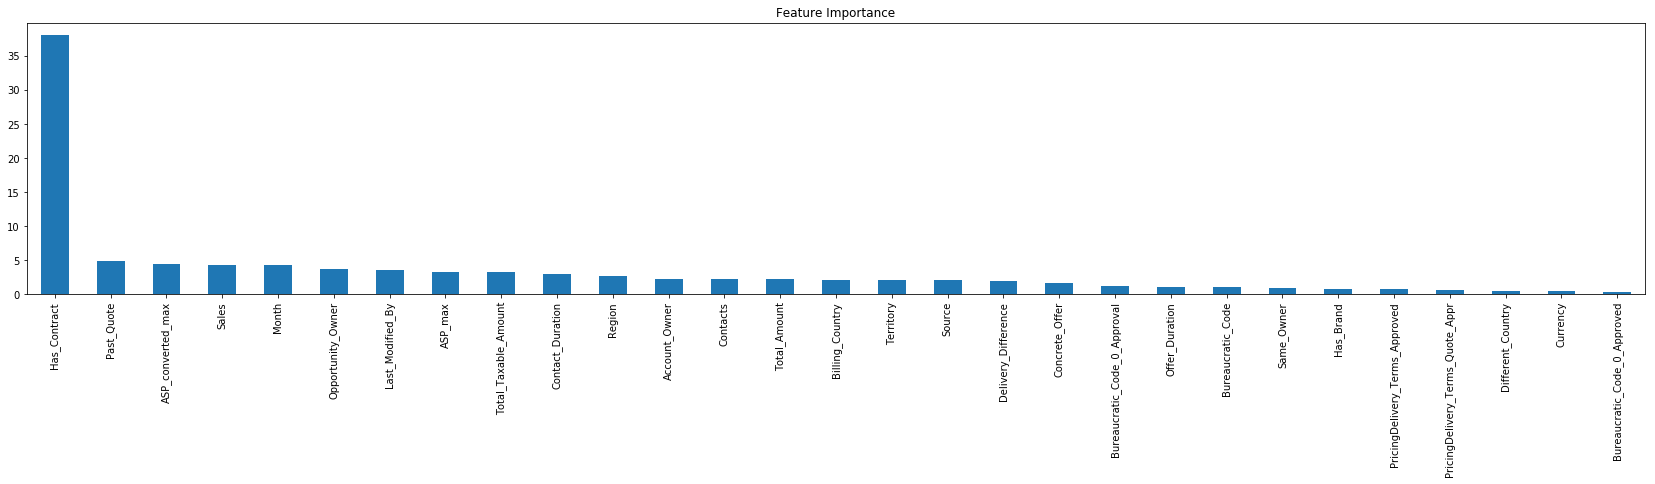

In [108]:
predictors = [x for x in x_train.drop(target, axis = 1).columns]
print len(predictors)
feat_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending = False)
feat_imp = feat_imp[0:29]
plt.rcParams['figure.figsize'] = 29, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

In [109]:
bad = x_test_pred[(x_test_pred.Prediction > 0.5) & (x_test_pred.Stage == 0) | (x_test_pred.Prediction < 0.5) & (x_test_pred.Stage == 1)]

In [110]:
len(bad)

87

In [111]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = model.predict_proba(validation.drop(leak, axis = 1))[:,1]

# agrupo por Opportunity_ID para dar una sola prediccion por solicitud

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
validation = validation.join(pred)

answer = pd.DataFrame(validation.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())

In [112]:
prev = pd.read_csv("best/modellgbold_pred.csv", names=["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9941804805935295

In [113]:
prev = pd.read_csv("best/model_xgb_pred.csv", names=["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9925355657931603

In [114]:
prev = pd.read_csv("best/modelada_pred.csv", names=["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9948767080633109

In [115]:
prev = pd.read_csv("best/modelcat_pred.csv", names=["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9979493120927454

In [116]:
prev = pd.read_csv("best/avg_lgb_xgb_ada_cat.csv", names=["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9975252520156652

In [117]:
catb = pd.read_csv("fabri/catb2.csv", names = ["Opportunity_ID", "Prediction"])
catb["Prediction"].corr(answer["Prediction"])

0.9984989852932961

In [118]:
answer.to_csv("catb_one_max.csv", header = False, index = False)

In [51]:
lgbm = pd.read_csv("fabri/lgbm.csv", names=["Id", "LGBM"])

In [52]:
xgb = pd.read_csv("fabri/xgb.csv", names=["Id", "XGB"]).drop("Id", axis=1)

In [53]:
catb = pd.read_csv("fabri/catb2.csv", names=["Id", "CATB"]).drop("Id", axis=1)

In [54]:
adab = pd.read_csv("fabri/adab2.csv", names=["Id", "ADAB"]).drop("Id", axis=1)

In [55]:
full = lgbm.join(xgb).join(catb).join(adab).drop('LGBM', axis=1)

In [56]:
full.XGB.corr(full.CATB)

0.9940014543236237

In [57]:
full.XGB.corr(full.ADAB)

0.9970269542862235

In [58]:
full.ADAB.corr(full.CATB)

0.9924745865832904

In [59]:
full.head()

,Id,XGB,CATB,ADAB
0,10689,0.997061,0.998040,0.998755
1,10690,0.992818,0.996455,0.997990
2,10691,0.975783,0.986605,0.985792
3,10692,0.976373,0.989770,0.997229
4,10693,0.972380,0.953184,0.995830


In [60]:
full["Final"] = full.apply(lambda x: calculate([x['CATB'], x['ADAB']], 0.001), axis=1)

In [48]:
def calculate(preds, offset):
    mean = sum(preds) / len(preds)
    return mean
    #return np.clip(mean, 0 + offset, 1 - offset)

In [548]:
full["Final"] = full.apply(lambda x: calculate([x['LGBM'], x['XGB'], x['CATB']]), axis=1)

In [61]:
full[["Id", "Final"]].to_csv("fabri/avg_adab2_catb2.csv", header = False, index = False)

In [563]:
modellgbold = pd.read_csv("best/modellgbold_pred.csv", names=["Id", "LGBOLD"])

In [564]:
modelcat = pd.read_csv("best/modelcat_pred.csv", names=["Id", "CATB"]).drop("Id", axis=1)

In [565]:
modelada = pd.read_csv("best/modelada_pred.csv", names=["Id", "ADA"]).drop("Id", axis=1)

In [566]:
modelxgb = pd.read_csv("best/model_xgb_pred.csv", names=["Id", "XGB"]).drop("Id", axis=1)

In [567]:
fullmodels = modellgbold.join(modelcat).join(modelada).join(modelxgb)

In [602]:
fullmodels.head(10)

,Id,LGBOLD,CATB,ADA,XGB,Final
0,10689,0.997994,0.997574,0.999471,0.996613,0.997913
1,10690,0.991791,0.994675,0.997299,0.979186,0.990738
2,10691,0.992083,0.969127,0.994164,0.908210,0.965896
3,10692,0.926446,0.978247,0.996771,0.980566,0.970507
4,10693,0.979495,0.967347,0.984526,0.968971,0.975085
5,10694,0.979495,0.976924,0.980587,0.928566,0.966393
6,10695,0.011361,0.000530,0.027921,0.066383,0.026549
7,10696,0.007405,0.000426,0.038997,0.063532,0.027590
8,10697,0.024714,0.001642,0.080582,0.142011,0.062237
9,10698,0.004736,0.000530,0.014155,0.009440,0.007215


In [601]:
fullmodels["Final"] = fullmodels.apply(lambda x: calculate([x['LGBOLD'], x['XGB'], x['ADA'], x['CATB']], 0.0005), axis=1)

In [1]:
fullmodels[["Id", "Final"]].to_csv("fabri/testsubimission9.csv", header = False, index = False)

NameError: name 'fullmodels' is not defined

In [ ]:
target_ensamble = ["Stage", "Opportunity_ID"]

ens_parameters = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': True,
    'boosting': 'gbdt',
    'feature_fraction': 0.3,
    'learning_rate': 0.05    
}

full_data = lgb.Dataset(data = df_ensamble.drop(target_ensamble, axis = 1), label = df_ensamble.Stage)
cv_results = lgb.cv(ens_parameters, full_data, num_boost_round = 1000, nfold = 5, early_stopping_rounds = 100)
cv_results["binary_logloss-mean"][-1]